# ROC curves with confidence intervals

The calculations described in this notebook, including all three methods for computing confidence intervals (bootstrapping, binomial formula and pessimistic approach) are now implemented in the function `tools.roc_with_ci` in `onfido-score-analysis`.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from score_analysis import Scores

In [3]:
sns.set_style("dark")

## Read anonymized sample data

In [4]:
df = pd.read_parquet("../data/data.parquet")

In [5]:
df.head()

,score,label,group
0,11.629738,pos,b
1,10.940947,pos,b
2,10.661779,pos,b
3,8.986903,pos,b
4,13.876004,pos,b


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164048 entries, 0 to 164047
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   score   164048 non-null  float64
 1   label   164048 non-null  object 
 2   group   164048 non-null  object 
dtypes: float64(1), object(2)
memory usage: 3.8+ MB


## Analysis

In [7]:
scores = Scores.from_labels(
    scores=df["score"],
    labels=df["label"],
    pos_label="pos",
    score_class="pos",
)

In [8]:
threshold, eer = scores.eer()
ci = scores.bootstrap_ci("eer")
print(f"Threshold: {threshold:.4f}. 95%-CI: ({ci[0, 0]:.4f}, {ci[0, 1]:.4f})")
print(f"EER: {eer:.3%}. 95%-CI: ({ci[1, 0]:.3%}, {ci[1, 1]:.3%})")

Threshold: 2.4252. 95%-CI: (2.3212, 2.5745)
EER: 0.239%. 95%-CI: (0.213%, 0.269%)


In [9]:
fnr = np.logspace(-4, -1, 200)
threshold = scores.threshold_at_fnr(fnr)
fpr = scores.fpr(threshold)
fnr = scores.fnr(threshold)

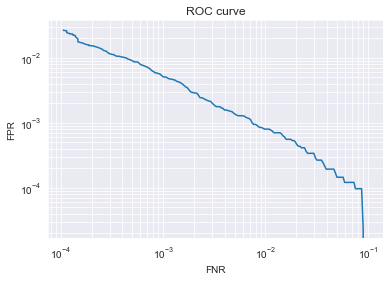

In [10]:
plt.figure()
plt.plot(fnr, fpr)
plt.xscale("log")
plt.yscale("log")
plt.grid(which="both")
plt.xlabel("FNR")
plt.ylabel("FPR")
plt.title("ROC curve")
plt.show()

## ROC curve with confidence intervals

In [11]:
def fpr_at_fnr(scores: Scores, fnr: np.ndarray) -> np.ndarray:
    """
    Calculates FPR at given FNR. 
    
    Used it to vectorize bootstrapping.
    """
    threshold = scores.threshold_at_fnr(fnr)
    fpr = scores.fpr(threshold)
    return fpr

### Method A: Regular bootstrap via replacement sampling

In [12]:
fnr = np.logspace(-4, -1, 200)

# The measured FPR values
fpr = fpr_at_fnr(scores, fnr)

# The confidence interval
fpr_ci = scores.bootstrap_ci(
    metric=partial(fpr_at_fnr, fnr=fnr),
    nb_samples=1000,
    method="replacement",
)

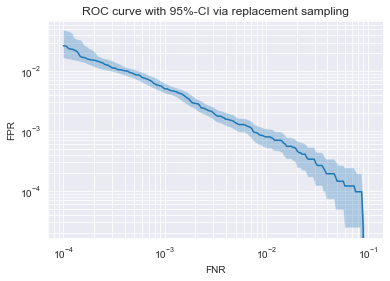

In [13]:
plt.figure()
plt.plot(fnr, fpr)
plt.fill_between(fnr, fpr_ci[:, 0], fpr_ci[:, 1], alpha=.3)
plt.xscale("log")
plt.yscale("log")
plt.grid(which="both")
plt.xlabel("FNR")
plt.ylabel("FPR")
plt.title("ROC curve with 95%-CI via replacement sampling")
plt.show()

### Method B: Binomial CI on FPR at fixed thresholds

In [14]:
fnr = np.logspace(-4, -1, 200)

# We compute the confusion matrices at these FNR values
threshold = scores.threshold_at_fnr(fnr)
cm = scores.cm(threshold)

# And then we look at the CIs for FPR
fpr_ci = cm.fpr_ci()

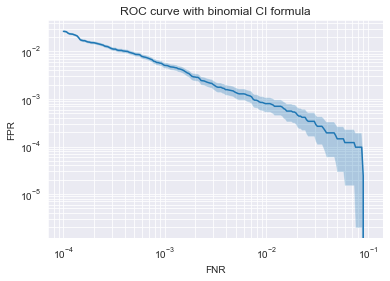

In [15]:
plt.figure()
plt.plot(fnr, fpr)
plt.fill_between(fnr, fpr_ci[:, 0], fpr_ci[:, 1], alpha=.3)
plt.xscale("log")
plt.yscale("log")
plt.grid(which="both")
plt.xlabel("FNR")
plt.ylabel("FPR")
plt.title("ROC curve with binomial CI formula")
plt.show()

This method shows larger confidence intervals in the low FPR range. This makes sense, since bootstrapping is not accurate in the case of rare events.

On the other hand, this method shows almost no uncertainty in the low FNR range. This also makes sense, because this method does not take into account the uncertainty of computing the threshold at a given FNR value. In contrast, method A, looks at the uncertainty of the full mapping FNR -> threshold -> FPR.

It should be noted that this method is much, much faster, since it is fully vectorized.

### Method C: The pessimist

We take the union of the confidence intervals generated by methods A and B.

In [21]:
def fpr_ci_pessimist(scores: Scores, fnr: np.ndarray) -> np.ndarray:
    """
    Calculates the CI for FPR using the pessimistic approach.
    """
    # Confidence interval via bootstrapping
    bootstrap_ci = scores.bootstrap_ci(
        metric=partial(fpr_at_fnr, fnr=fnr),
        nb_samples=1000,
        method="replacement",
    )
    
    # Binomial confidence interval
    threshold = scores.threshold_at_fnr(fnr)
    cm = scores.cm(threshold)
    binomial_ci = cm.fpr_ci()
    
    # Take the worst ones
    lower = np.minimum(bootstrap_ci[:, 0], binomial_ci[:, 0])
    upper = np.maximum(bootstrap_ci[:, 1], binomial_ci[:, 1])
    ci = np.stack([lower, upper], axis=-1)
    
    return ci

In [22]:
fnr = np.logspace(-4, -1, 200)

fpr = fpr_at_fnr(scores, fnr)
fpr_ci = fpr_ci_pessimist(scores, fnr)

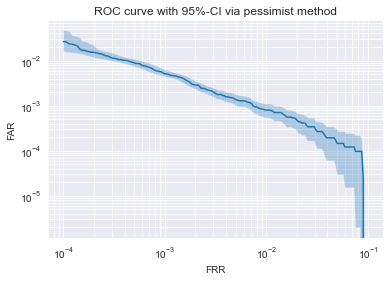

In [23]:
plt.figure()
plt.plot(fnr, fpr)
plt.fill_between(fnr, fpr_ci[:, 0], fpr_ci[:, 1], alpha=.3)
plt.xscale("log")
plt.yscale("log")
plt.grid(which="both")
plt.xlabel("FRR")
plt.ylabel("FAR")
plt.title("ROC curve with 95%-CI via pessimist method")
plt.show()

### Method D: Bootstrapping using proportional sampling of 80% of data

This method is included only for illustrative purposes. Considering how small the confidence intervals are, I wouldn't recommend using it.

In [24]:
fnr = np.logspace(-4, -1, 200)

fpr = fpr_at_fnr(scores, fnr)
fpr_ci = scores.bootstrap_ci(
    metric=partial(fpr_at_fnr, fnr=fnr),
    nb_samples=1000,
    method="proportion",
    ratio=0.8,
)

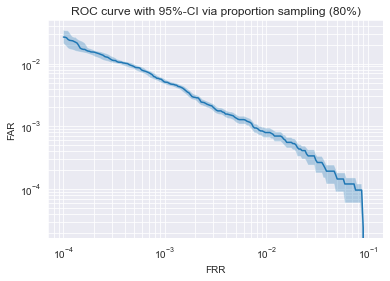

In [25]:
plt.figure()
plt.plot(fnr, fpr)
plt.fill_between(fnr, fpr_ci[:, 0], fpr_ci[:, 1], alpha=.3)
plt.xscale("log")
plt.yscale("log")
plt.grid(which="both")
plt.xlabel("FRR")
plt.ylabel("FAR")
plt.title("ROC curve with 95%-CI via proportion sampling (80%)")
plt.show()